In [ ]:
!pip install yfinance
!pip install scikit-learn
!pip install matplotlib
!pip install pandas

In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

In [3]:
sp500 = yf.Ticker("^GSPC")

In [4]:
sp500 = sp500.history(period = "max")

<Axes: xlabel='Date'>

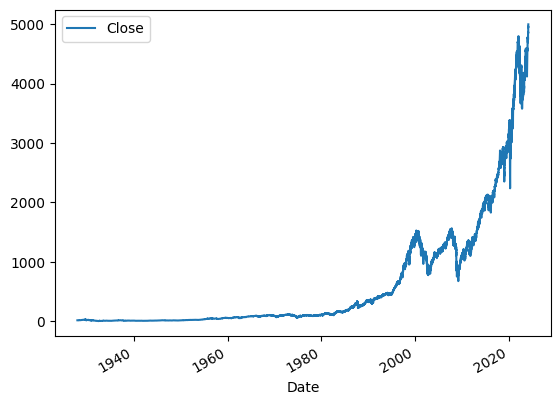

In [6]:
sp500.plot.line(y="Close", use_index=True)

In [7]:
del sp500["Dividends"]
del sp500["Stock Splits"]

In [8]:
sp500["Tomorrow"] = sp500["Close"].shift(-1)

In [9]:
sp500["Target"] = (sp500["Tomorrow"] > sp500["Close"]).astype(int)

In [11]:
sp500 = sp500.loc["2000-01-01":].copy()

In [ ]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, min_samples_split=100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ["Close", "Volume", "Open", "High", "Low"]
model.fit(train[predictors], train["Target"])


In [14]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])

In [15]:

preds = pd.Series(preds, index=test.index)

In [40]:
preds

Date
2023-09-15 00:00:00-04:00    0
2023-09-18 00:00:00-04:00    0
2023-09-19 00:00:00-04:00    1
2023-09-20 00:00:00-04:00    0
2023-09-21 00:00:00-04:00    1
                            ..
2024-02-01 00:00:00-05:00    0
2024-02-02 00:00:00-05:00    0
2024-02-05 00:00:00-05:00    0
2024-02-06 00:00:00-05:00    0
2024-02-07 00:00:00-05:00    0
Length: 100, dtype: int32

In [17]:
precision_score(test["Target"], preds)

0.5581395348837209

In [18]:
combined = pd.concat([test["Target"], preds], axis=1)

##### combined.plot()

In [19]:
import pandas as pd

def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict(test[predictors])
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [20]:
import pandas as pd
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []

    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [21]:
predictions = backtest(sp500, model, predictors)

In [22]:
predictions["Predictions"].value_counts()

Predictions
1    1842
0    1721
Name: count, dtype: int64

In [23]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5228013029315961

In [24]:
predictions["Target"].value_counts() / predictions.shape[0]

Target
1    0.543924
0    0.456076
Name: count, dtype: float64

In [25]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500.rolling(horizon).mean()

    ratio_column = f"Close_Ratio_{horizon}"
    sp500[ratio_column] = sp500["Close"] / rolling_averages["Close"]

    trend_column = f"Trend_{horizon}"
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()["Target"]

new_predictors += [ratio_column, trend_column]

In [26]:
sp500 = sp500.dropna()

In [28]:
model = RandomForestClassifier(n_estimators=200, min_samples_split=50, random_state=1)

In [41]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train["Target"])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .5] = 1
    preds[preds < .5] = 0
    preds = pd.Series(preds, index=test.index, name="Predictions")
    combined = pd.concat([test["Target"], preds], axis=1)
    return combined

In [42]:
predictions = backtest(sp500, model, new_predictors)

In [43]:
predictions["Predictions"].value_counts()

Predictions
1.0    1453
0.0    1109
Name: count, dtype: int64

In [44]:
precision_score(predictions["Target"], predictions["Predictions"])

0.5375086028905712

In [57]:
def add_macd_indicators(df):
    df = df.copy()  # Make a copy to ensure modifications are made on a new object
    df['EMA12'] = df['Close'].ewm(span=12, adjust=False).mean()    # ewm = exponential Weigthed Moving Average
    df['EMA26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA12'] - df['EMA26']
    df['Signal_Line'] = df['MACD'].ewm(span=9, adjust=False).mean()
    return df

In [58]:
sp500 = add_macd_indicators(sp500)

In [59]:
new_predictors = ["MACD", "Signal_Line"]

In [60]:
predictions = backtest(sp500, model, new_predictors)

In [61]:
predictions["Predictions"].value_counts()

Predictions
1.0    1604
0.0     958
Name: count, dtype: int64

In [62]:
precision_score(predictions["Target"], predictions["Predictions"])

0.520573566084788

In [56]:
sp500

,Open,High,Low,Close,Volume,Tomorrow,Target,Close_Ratio_2,Trend_2,Close_Ratio_5,...,Close_Ratio_60,Trend_60,Close_Ratio_250,Trend_250,Close_Ratio_1000,Trend_1000,EMA12,EMA26,MACD,Signal_Line
Date,,,,,,,,,,,,,,,,,,,,,
2003-12-26 00:00:00-05:00,1094.040039,1098.469971,1094.040039,1095.890015,356070000,1109.479980,1,1.000845,1.0,1.002176,...,1.039354,34.0,1.137825,135.0,0.957328,485.0,1095.890015,1095.890015,0.000000,0.000000
2003-12-29 00:00:00-05:00,1095.890015,1109.479980,1095.890015,1109.479980,1058800000,1109.640015,1,1.006162,2.0,1.010755,...,1.050761,34.0,1.150837,135.0,0.969445,486.0,1097.980779,1096.896679,1.084100,0.216820
2003-12-30 00:00:00-05:00,1109.479980,1109.750000,1106.410034,1109.640015,1012600000,1111.920044,1,1.000072,2.0,1.007835,...,1.049591,34.0,1.150046,135.0,0.969833,486.0,1099.774507,1097.840630,1.933878,0.560232
2003-12-31 00:00:00-05:00,1109.640015,1112.560059,1106.209961,1111.920044,1027500000,1108.479980,0,1.001026,2.0,1.006997,...,1.050463,34.0,1.151439,136.0,0.972073,486.0,1101.643051,1098.883549,2.759502,1.000086
2004-01-02 00:00:00-05:00,1111.920044,1118.849976,1105.079956,1108.479980,1153200000,1122.219971,1,0.998451,1.0,1.001263,...,1.046073,33.0,1.147024,135.0,0.969348,485.0,1102.694887,1099.594396,3.100491,1.420167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-31 00:00:00-05:00,4899.189941,4906.750000,4845.149902,4845.649902,4696120000,4906.189941,1,0.991882,0.0,0.989567,...,1.039463,39.0,1.112925,136.0,1.210560,527.0,4855.780539,4799.220411,56.560128,54.941814
2024-02-01 00:00:00-05:00,4861.109863,4906.970215,4853.520020,4906.189941,4386090000,4958.609863,1,1.006208,1.0,1.001439,...,1.050393,39.0,1.126078,136.0,1.225211,527.0,4863.535832,4807.144080,56.391752,55.231802
2024-02-02 00:00:00-05:00,4916.060059,4975.290039,4907.990234,4958.609863,3974350000,4942.810059,0,1.005314,2.0,1.009351,...,1.059375,39.0,1.137251,137.0,1.237813,527.0,4878.162606,4818.363768,59.798838,56.145209
